In [1]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from scipy.spatial.distance import cdist
from sklearn.neighbors import KNeighborsRegressor

In [2]:
data = pd.read_csv("./train.csv")
subspures = pd.read_csv("./substances.csv")
pure_heroin = subspures[(subspures['substance'] == 'heroin (white)') | (subspures["substance"]=="heroin (brown)")]

In [3]:
distances = cdist(data.iloc[:,6:].to_numpy(), pure_heroin.iloc[:, 1:].to_numpy(), metric = 'euclidean')
dist_her = pd.DataFrame(distances, index = data.iloc[:,6:].index, columns=pure_heroin.iloc[:,1:].index)

In [ ]:
#normalized_data = preprocessing.normalize(data.iloc[:, 6:].values)
#normalized_substances = preprocessing.normalize(subspures.iloc[:,1:].values)
data_new_features2 = data.iloc[:, 6:].values.dot(subspures.iloc[:,1:].values.T)
#data_new_features2_pd = pd.DataFrame(data_new_features2, index=data.iloc[:,6:].index, columns=subspures.iloc[:,1:].index)

In [13]:
"""
spectrum = data.iloc[:, 6:]
spectrum_filtered = pd.DataFrame(savgol_filter(spectrum, 7, 3, deriv = 2, axis = 0))
spectrum_filtered_st = zscore(spectrum_filtered, axis = 1)"""

X = pd.DataFrame(data_new_features2)
y = data['PURITY']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

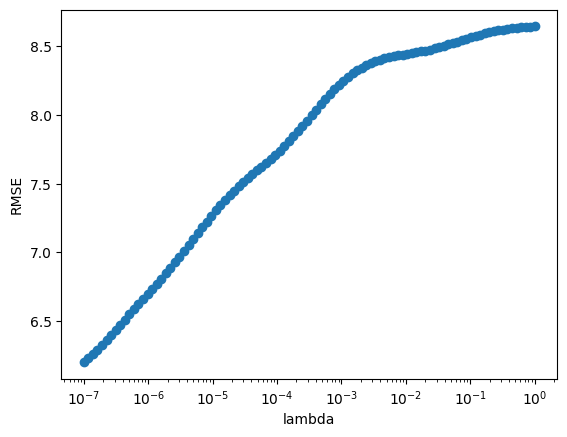

In [6]:
model = Ridge() #ridge regressors model
param_grid = {'alpha': np.logspace(-7, 0, 100)} #hyperparamater alpha

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

mach1 = grid_search.best_estimator_ #best model
mach1.fit(X_train, y_train) #apply the best model to the data
predictions = mach1.predict(X_valid)

plt.figure()
plt.scatter(np.logspace(-7, 0, 100),        
            np.sqrt(-grid_search.cv_results_['mean_test_score']))
plt.xlabel("lambda")
plt.ylabel("RMSE")
plt.xscale("log")
plt.show()

In [7]:
mach1.get_params()

{'alpha': 1e-07,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [8]:
y_pred1 = mach1.predict(X_train)
y_pred2 = mach1.predict(X_valid)
train_score = np.mean(np.abs(y_pred1-y_train<=5))
test_score = np.mean(np.abs(y_pred2-y_valid<=5))
print("Train score ridge :", train_score)
print("Test score ridge :", test_score)

Train score ridge : 0.820814479638009
Test score ridge : 0.8256410256410256


In [9]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
nested_scores=cross_val_score(mach1, X, y, cv=outer_cv, scoring='neg_mean_squared_error')

print(nested_scores) 

('Average error:', np.sqrt(-nested_scores).mean(), "Per fold:", np.sqrt(-nested_scores))

[-37.06041561 -33.46874474 -35.66276686 -38.63553625 -46.24582619]


('Average error:',
 6.172190592450592,
 'Per fold:',
 array([6.08772664, 5.78521778, 5.97183111, 6.21574905, 6.80042838]))

In [14]:
def fit_and_evaluate(K:int, x_train:pd.DataFrame, x_valid:pd.DataFrame, Y_train, Y_valid)->dict:
    model = KNeighborsRegressor(n_neighbors=K)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid)
    return {
        "training_error": np.sqrt(mean_squared_error(model.predict(x_train), Y_train)),
        "test_error": np.sqrt(mean_squared_error(model.predict(x_valid), Y_valid)),
        "prediction": y_pred,
    }

KNN = fit_and_evaluate(40, X_train, X_valid, y_train, y_valid)

In [15]:
# cross-validation function
def cross_validation(idxs, nfolds=5):
    n = int(np.ceil(len(idxs) / nfolds))
    validation_sets = [idxs[k * n : min((k + 1) * n, len(idxs))] for k in range(nfolds)]
    train_sets = [list(set(idxs) - set(validation_set)) for validation_set in validation_sets]
    return {'train_sets': train_sets, 'validation_sets': validation_sets}

def nested_cross_validation(idxs, inner_nfolds=5, outer_nfolds=5):
    outer = cross_validation(idxs, nfolds=outer_nfolds)
    results = []

    # Parcourir les folds externes
    for te, tr in zip(outer['validation_sets'], outer['train_sets']):
        
        # Validation croisée interne pour optimiser les hyperparamètres
        inner = cross_validation(tr, nfolds=inner_nfolds)
        
        best_score = float('inf')  # Initialiser avec un score très élevé
        best_k = None  # Initialiser le meilleur k à None

        # Essayer différentes valeurs de K dans la validation croisée interne
        k_range = range(10, 40)  # Tester les valeurs de K de 1 à 20
        for k in k_range:
            score = 0  # Calculer la moyenne des scores pour ce k
            
            for inner_train, inner_test in zip(inner['train_sets'], inner['validation_sets']):
                X_train, X_val = X.iloc[inner_train], X.iloc[inner_test]
                y_train, y_val = y.iloc[inner_train], y.iloc[inner_test]
                
                model = KNeighborsRegressor(n_neighbors=k)
                model.fit(X_train, y_train)
                score += np.sqrt(mean_squared_error(y_val, model.predict(X_val)))  # Accumuler les scores
                
            avg_score = score / inner_nfolds  # Moyenne des scores pour ce K
            
            # Si ce K donne un meilleur score, on met à jour best_score et best_k
            if avg_score < best_score:
                best_score = avg_score
                best_k = k

        # Evaluation sur le fold externe avec le meilleur K trouvé
        X_train, X_test = X.iloc[tr], X.iloc[te]
        y_train, y_test = y.iloc[tr], y.iloc[te]
        
        model = KNeighborsRegressor(n_neighbors=best_k)  # Utiliser le meilleur K
        model.fit(X_train, y_train)
        test_error = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

        # Sauvegarder les résultats de ce fold externe
        results.append({
            'test_set': te,
            'best_k': best_k,
            'best_score': best_score,
            'test_error': test_error
        })
    
    return results

In [16]:
# Exemple d'utilisation
idxs = list(range(len(X_train)))  # Indices de vos données d'entraînement
results = nested_cross_validation(idxs, inner_nfolds=5, outer_nfolds=5)

# Affichage des résultats
for result in results:
    print(f"Best K: {result['best_k']}")
    print(f"Best internal validation score (MSE): {result['best_score']}")
    print(f"Test error (MSE): {result['test_error']}")
    print("-" * 50)

t_score = np.mean(np.abs(KNN["prediction"] - y_valid) <= 5)
print(t_score)

Best K: 10
Best internal validation score (MSE): 10.216934219273003
Test error (MSE): 8.494438506753553
--------------------------------------------------
Best K: 10
Best internal validation score (MSE): 9.80352387919545
Test error (MSE): 9.815761630770174
--------------------------------------------------
Best K: 10
Best internal validation score (MSE): 10.029125173788035
Test error (MSE): 9.335734591403941
--------------------------------------------------
Best K: 11
Best internal validation score (MSE): 9.718996216896874
Test error (MSE): 10.666221443585648
--------------------------------------------------
Best K: 10
Best internal validation score (MSE): 9.73875464393478
Test error (MSE): 9.878408390557
--------------------------------------------------
0.4666666666666667
